In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
audio_path = "/content/drive/MyDrive/Audio_Speech_Actors_01-24"

In [16]:
import os

for root, dirs, files in os.walk(audio_path):
    for file in files:
        if file.endswith(".wav"):
            file_path = os.path.join(root, file)
            # process file_path here


     CLASSIFICATION REPORT    

              precision    recall  f1-score   support

       angry       0.09      0.08      0.08        38
        calm       0.18      0.21      0.20        38
     disgust       0.26      0.24      0.25        38
     fearful       0.24      0.21      0.22        39
       happy       0.12      0.10      0.11        39
     neutral       0.23      0.16      0.19        19
         sad       0.17      0.21      0.19        38
   surprised       0.24      0.31      0.27        39

    accuracy                           0.19       288
   macro avg       0.19      0.19      0.19       288
weighted avg       0.19      0.19      0.19       288


Test Accuracy: 19.10%


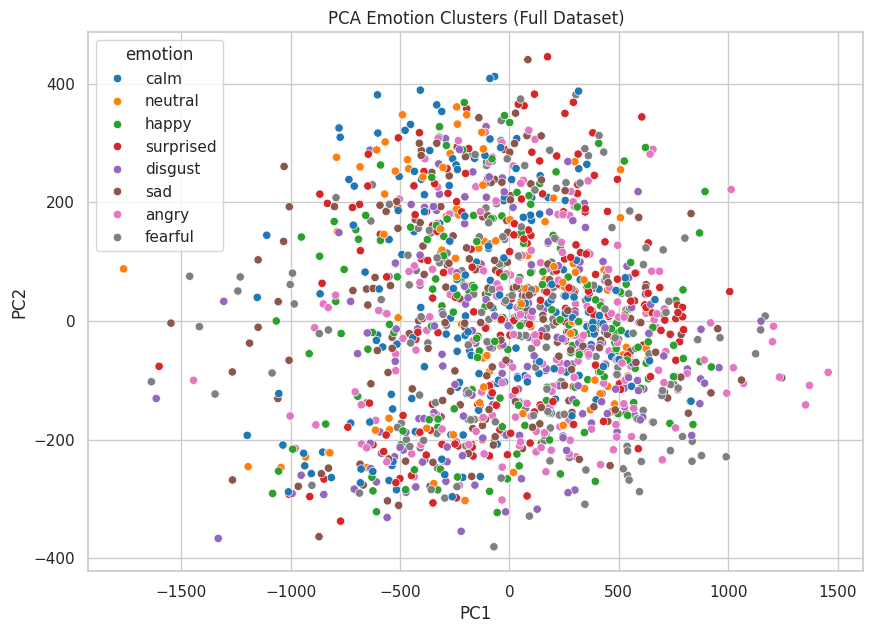


Robustness Test on: /content/drive/MyDrive/Audio_Speech_Actors_01-24/Actor_08/03-01-07-02-02-01-08.wav

Robustness Test Results:
original   → disgust
noise      → angry
pitch_up   → fearful
speed_up   → fearful
louder     → disgust


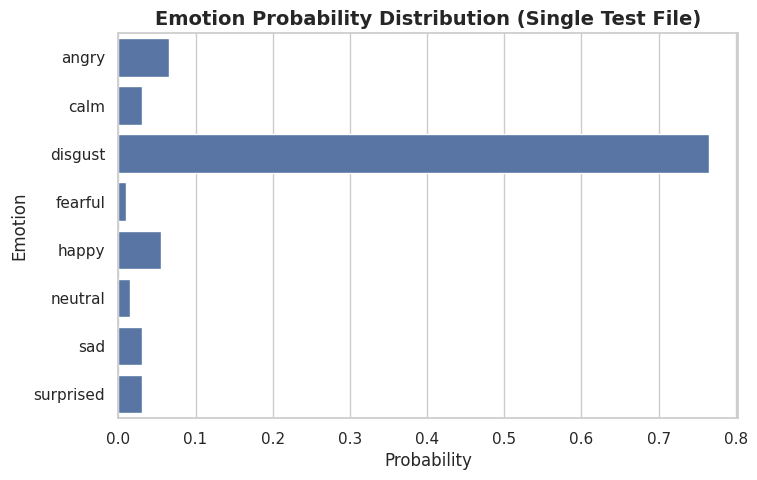


Final Verdict: The emotion is most consistently classified as → DISGUST


In [31]:
#1. Import :D
import os
import numpy as np
import pandas as pd
import librosa
import librosa.feature as lf
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.decomposition import PCA
import random

sns.set(style="whitegrid")

audio_path = "/content/drive/MyDrive/Audio_Speech_Actors_01-24"

#2. Extracting features :D

def extract_features_fast(file_path, sr_target=16000):
    y, sr = librosa.load(file_path, sr=sr_target)
    return np.array([
        np.mean(lf.zero_crossing_rate(y)),
        np.mean(lf.spectral_centroid(y=y, sr=sr)),
        np.mean(lf.spectral_bandwidth(y=y, sr=sr)),
        np.mean(lf.spectral_rolloff(y=y, sr=sr))
    ])

feature_names = ["zcr", "centroid", "bandwidth", "rolloff"]

#3. Map all the emotions
emotion_map = {
    "01": "neutral", "02": "calm", "03": "happy", "04": "sad",
    "05": "angry", "06": "fearful", "07": "disgust", "08": "surprised"
}

#4. Load dataset (lessgoooo)
X, y = [], []
for root, dirs, files in os.walk(audio_path):
    for file in files:
        if file.endswith(".wav"):
            parts = file.split("-")
            if len(parts) >= 3:
                emo = parts[2]
                if emo in emotion_map:
                    feats = extract_features_fast(os.path.join(root, file))
                    X.append(feats)
                    y.append(emotion_map[emo])

X = np.array(X)
y = np.array(y)

df = pd.DataFrame(X, columns=feature_names)
df["emotion"] = y

#5. Split the data to train and test (vip)

X_train, X_test, y_train, y_test = train_test_split(
    df[feature_names], df["emotion"],
    test_size=0.2, random_state=42, stratify=df["emotion"]
)


model = RandomForestClassifier(n_estimators=200)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("\n==============================")
print("     CLASSIFICATION REPORT    ")
print("==============================\n")
print(classification_report(y_test, y_pred))

test_acc = accuracy_score(y_test, y_pred)
print(f"\nTest Accuracy: {test_acc:.2%}")

#6. PCA emotion clusters
pca = PCA(n_components=2)
pca_vals = pca.fit_transform(df[feature_names])

plt.figure(figsize=(10, 7))
sns.scatterplot(x=pca_vals[:, 0], y=pca_vals[:, 1], hue=df["emotion"], palette="tab10")
plt.title("PCA Emotion Clusters (Full Dataset)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

#7. Robustness test

def add_noise(y, noise_factor=0.02):
    return y + noise_factor * np.random.randn(len(y))

def change_pitch(y, sr, n_steps=4):
    return librosa.effects.pitch_shift(y=y, sr=sr, n_steps=n_steps)

def change_speed(y, speed=1.25):
    return librosa.effects.time_stretch(y=y, rate=speed)

def change_volume(y, gain=1.5):
    return y * gain

def robustness_test(file_path):
    y, sr = librosa.load(file_path, sr=16000)
    variants = {
        "original": y,
        "noise": add_noise(y),
        "pitch_up": change_pitch(y, sr, 4),
        "speed_up": change_speed(y, 1.3),
        "louder": change_volume(y, 1.8)
    }
    results = {}
    for name, audio in variants.items():
        feats = np.array([
            np.mean(lf.zero_crossing_rate(audio)),
            np.mean(lf.spectral_centroid(y=audio, sr=sr)),
            np.mean(lf.spectral_bandwidth(y=audio, sr=sr)),
            np.mean(lf.spectral_rolloff(y=audio, sr=sr))
        ]).reshape(1, -1)
        pred = model.predict(pd.DataFrame(feats, columns=feature_names))[0]
        results[name] = pred
    return results

test_file = random.choice([
    os.path.join(root, file)
    for root, dirs, files in os.walk(audio_path)
    for file in files if file.endswith(".wav")
])

print("\nRobustness Test on:", test_file)
results = robustness_test(test_file)

print("\nRobustness Test Results:")
for variant, emotion in results.items():
    print(f"{variant:10s} → {emotion}")


#8. Bar chart (probability) :))

def predict_with_probs(file_path):
    feats = extract_features_fast(file_path).reshape(1, -1)
    feats_df = pd.DataFrame(feats, columns=feature_names)
    probs = model.predict_proba(feats_df)[0]
    return model.classes_, probs

classes, probs = predict_with_probs(test_file)

plt.figure(figsize=(8, 5))
sns.barplot(x=probs, y=classes)
plt.title("Emotion Probability Distribution (Single Test File)", fontsize=14, weight='bold')
plt.xlabel("Probability")
plt.ylabel("Emotion")
plt.show()

#9. FINALLLL :D

from collections import Counter
final_emotion = Counter(results.values()).most_common(1)[0][0]
print(f"\nFinal Verdict: The emotion is most consistently classified as → {final_emotion.upper()}")